# Task 2

Imports

In [115]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix
import tsfel
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.metrics import accuracy_score


In [116]:
def load_data():
    # Constants
    time = 10
    offset = 100
    folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
    classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

    combined_dir = os.path.join("Combined")

    X_train=[]
    y_train=[]
    dataset_dir = os.path.join(combined_dir,"Train")

    for folder in folders:
        files = os.listdir(os.path.join(dataset_dir,folder))

        for file in files:

            df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
            df = df[offset:offset+time*50]
            X_train.append(df.values)
            y_train.append(classes[folder])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test=[]
    y_test=[]
    dataset_dir = os.path.join(combined_dir,"Test")

    for folder in folders:
        files = os.listdir(os.path.join(dataset_dir,folder))
        for file in files:

            df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
            df = df[offset:offset+time*50]
            X_test.append(df.values)
            y_test.append(classes[folder])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X = np.concatenate((X_train,X_test))
    y = np.concatenate((y_train,y_test))

    seed = 4
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

    print("Training data shape: ",X_train.shape)
    print("Testing data shape: ",X_test.shape)

    return X_train,X_test,y_train,y_test

Load data

In [117]:
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
X_train,X_test,y_train,y_test = load_data()

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


Let's try to plot and see how the different activities look like

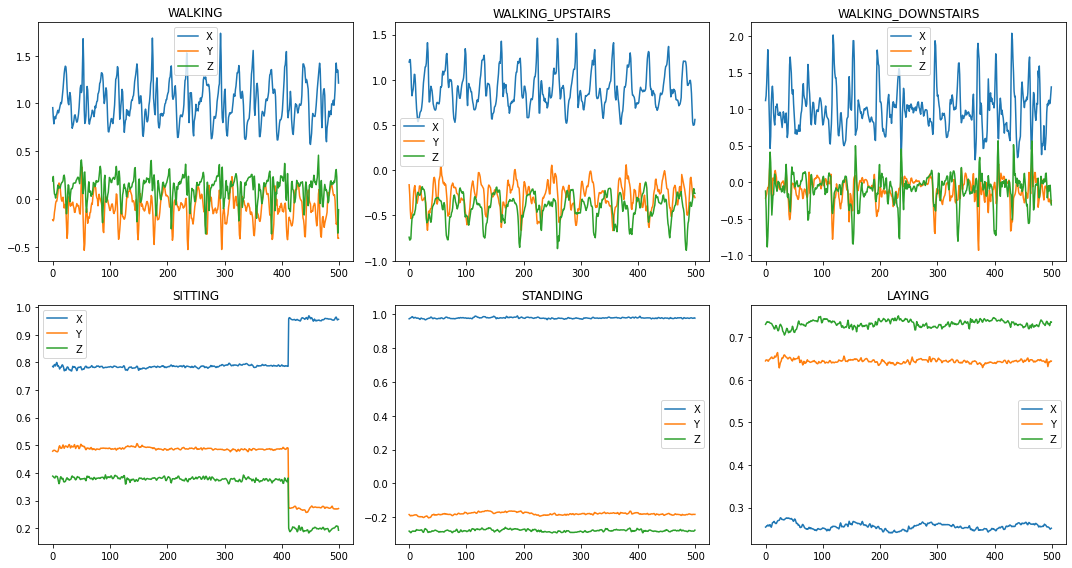

In [118]:
# Let's collect the first instance of every class and plot them

samples={}
for activity,label in classes.items():
    idx=np.where(y_train==label)[0][0]
    samples[activity]=X_train[idx]

plt.figure(figsize=(15,8))

for i,(activity,data) in enumerate(samples.items()):
    plt.subplot(2,3,i+1)
    plt.plot(data[:,0],label='X')
    plt.plot(data[:,1],label='Y')
    plt.plot(data[:,2],label='Z')
    plt.title(activity)
    plt.legend()
plt.tight_layout()

Clealry the moving and static activites are different, can be distinguished easily, but it is quite difficult to distinguish among moving activities and static activities (with naked eyes) 

### Q1 Use Sklearn Library to train Decision Trees.

##### (i) Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

In [119]:
# flattening the raw accelerometer data, for trainnig a tree

X_train_flat=X_train.reshape(126,1500)
X_test_flat=X_test.reshape(54,1500)

In [120]:
# Training a decision tree

tree_raw=DecisionTreeClassifier(random_state=42)
tree_raw.fit(X_train_flat,y_train)
predictions_raw=tree_raw.predict(X_test_flat)

In [121]:
# Classification Report

print(classification_report(y_test,predictions_raw))

              precision    recall  f1-score   support

           1       0.25      0.22      0.24         9
           2       0.50      0.56      0.53         9
           3       0.25      0.11      0.15         9
           4       0.67      0.89      0.76         9
           5       0.80      0.89      0.84         9
           6       0.90      1.00      0.95         9

    accuracy                           0.61        54
   macro avg       0.56      0.61      0.58        54
weighted avg       0.56      0.61      0.58        54



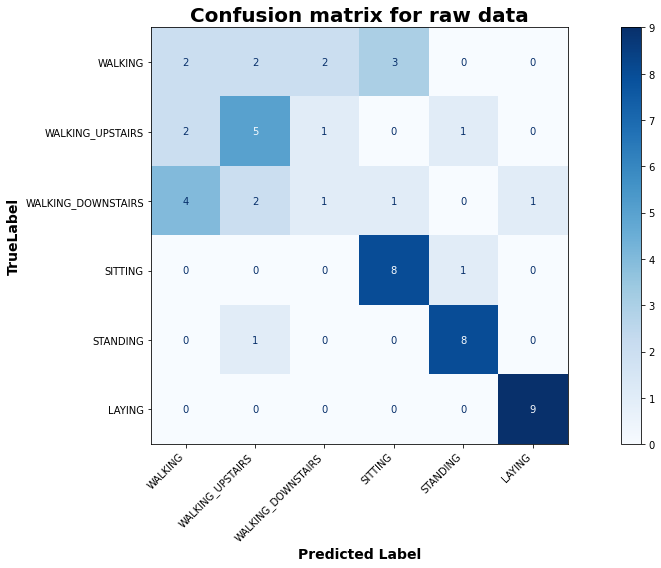

In [122]:
# Plotting confusion matrix 

cm=confusion_matrix(y_test,predictions_raw)
cm_beautified=ConfusionMatrixDisplay(cm,display_labels=classes)
fig, ax = plt.subplots(figsize=(15, 8))  
cm_beautified.plot(cmap='Blues', ax=ax)
plt.title('Confusion matrix for raw data',fontweight='bold',fontsize=20)
plt.xticks(rotation=45,ha='right')
plt.yticks()
plt.xlabel('Predicted Label',fontweight='bold',fontsize=14)
plt.ylabel('TrueLabel',fontweight='bold',fontsize=14)
plt.tight_layout()

-> Inferences

* As we had seen earlier in the time series plots, the static activities are easier to distinguish as compared to dynamic ones.

* One important thing to observe here is that the activity "Laying" outperforms every other activity. We will see in the notebook ahead, why this is the case.  


Now, let's see some wrongly classified activities and try to understand the reason

* We can see that walking down is misclassified as walking (which is the most confusing pair), let's try to see their plots

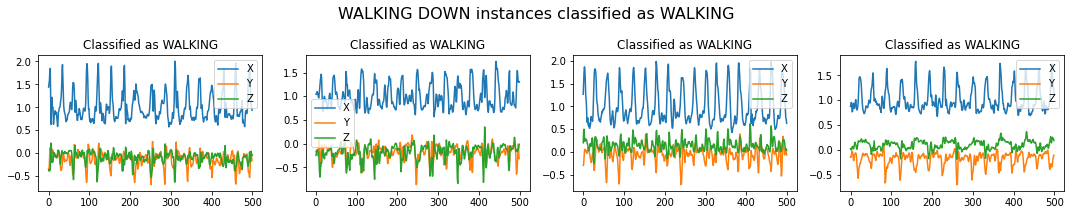

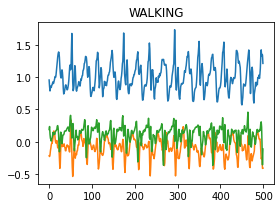

In [123]:
# Finding the misclassified instances of walking down as walking
misclassified={}
for idx,label in enumerate(predictions_raw):
    if label==1 and y_test[idx]==3:
        misclassified[idx]=X_test[idx]

# Plotting the instances
fig=plt.figure(figsize=(15,3))
fig.suptitle('WALKING DOWN instances classified as WALKING',fontsize=16)
for i,(idx,data) in enumerate(misclassified.items()):
    plt.subplot(1,4,i+1)
    plt.plot(data[:,0],label='X')
    plt.plot(data[:,1],label='Y')
    plt.plot(data[:,2],label='Z')
    plt.legend()
    plt.title('Classified as WALKING')
plt.tight_layout()
ax=plt.figure(figsize=(4,3))
plt.plot(samples['WALKING'])
plt.title('WALKING')
plt.tight_layout()

Lets try some other plot to confirm the similarity

c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'WALKING')

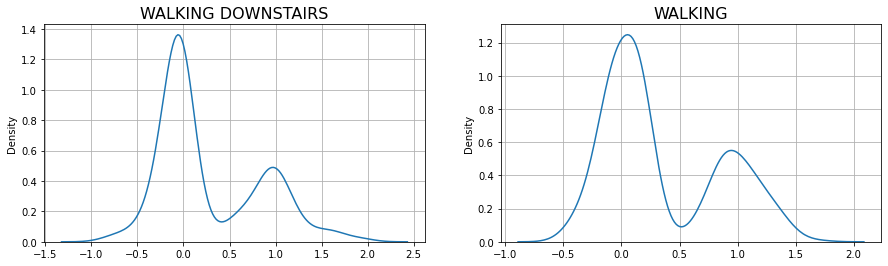

In [124]:
for activity,data in samples.items():
    samples[activity]=data.reshape(1500)

# sns.set_palette()
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.grid(True)
sns.kdeplot(samples['WALKING_DOWNSTAIRS'])
plt.title('WALKING DOWNSTAIRS',fontsize=16)

plt.subplot(1,2,2)
plt.grid(True)
sns.kdeplot(samples['WALKING'])
plt.title('WALKING',fontsize=16)


##### (ii) Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.

In [125]:
# Initializing time series feature extraction library (tsfel) and extracting the features

tsfel_features=tsfel.get_features_by_domain()  # Get Features from various domains like statistical, temporal and spectral.
X_train_tsfel=tsfel.time_series_features_extractor(tsfel_features,X_train,fs=50)

*** Feature extraction started ***



*** Feature extraction finished ***


In [126]:
# Extract features for x test as well
X_test_tsfel=tsfel.time_series_features_extractor(tsfel_features,X_test,fs=50)

*** Feature extraction started ***



*** Feature extraction finished ***


Let's train a Decision tree on the extracted features and see the performance

In [127]:
# Decision tree initialization , training and prediction

tree_tsfel=DecisionTreeClassifier(random_state=42)
tree_tsfel.fit(X_train_tsfel,y_train)
predictions_tsfel=tree_tsfel.predict(X_test_tsfel)

CLASSIFICATION REPORT FOR TREE

In [128]:
print(classification_report(y_test,predictions_tsfel))

              precision    recall  f1-score   support

           1       0.86      0.67      0.75         9
           2       0.73      0.89      0.80         9
           3       0.78      0.78      0.78         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         9

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54



CONFUSION MATRIX FOR TREE

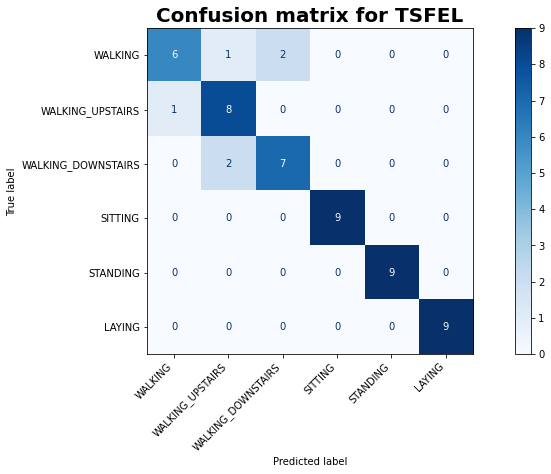

In [129]:
cm=confusion_matrix(y_test,predictions_tsfel)
cm_beautified=ConfusionMatrixDisplay(cm,display_labels=classes)
fig,ax=plt.subplots(figsize=(15,6))
cm_beautified.plot(cmap='Blues',ax=ax)
plt.title('Confusion matrix for TSFEL',fontweight='bold',fontsize=20)
plt.xticks(rotation=45,ha='right')
plt.show()

OBSERVATIONS

* The model is performing very good on static activities, there are some misclassificaitons in the dynamic activities but overall the model is much better than the decision tree trained earlier on the raw data. 

* This is because of the fact that the tsfel is designed to extract the underlying complex features from a timeseries data which is very hard to interpret just from the raw data.

* Tsfel extracts features from various domains like temporal, statistical, and spectral.

Let us see some of the features engineered by tsfel

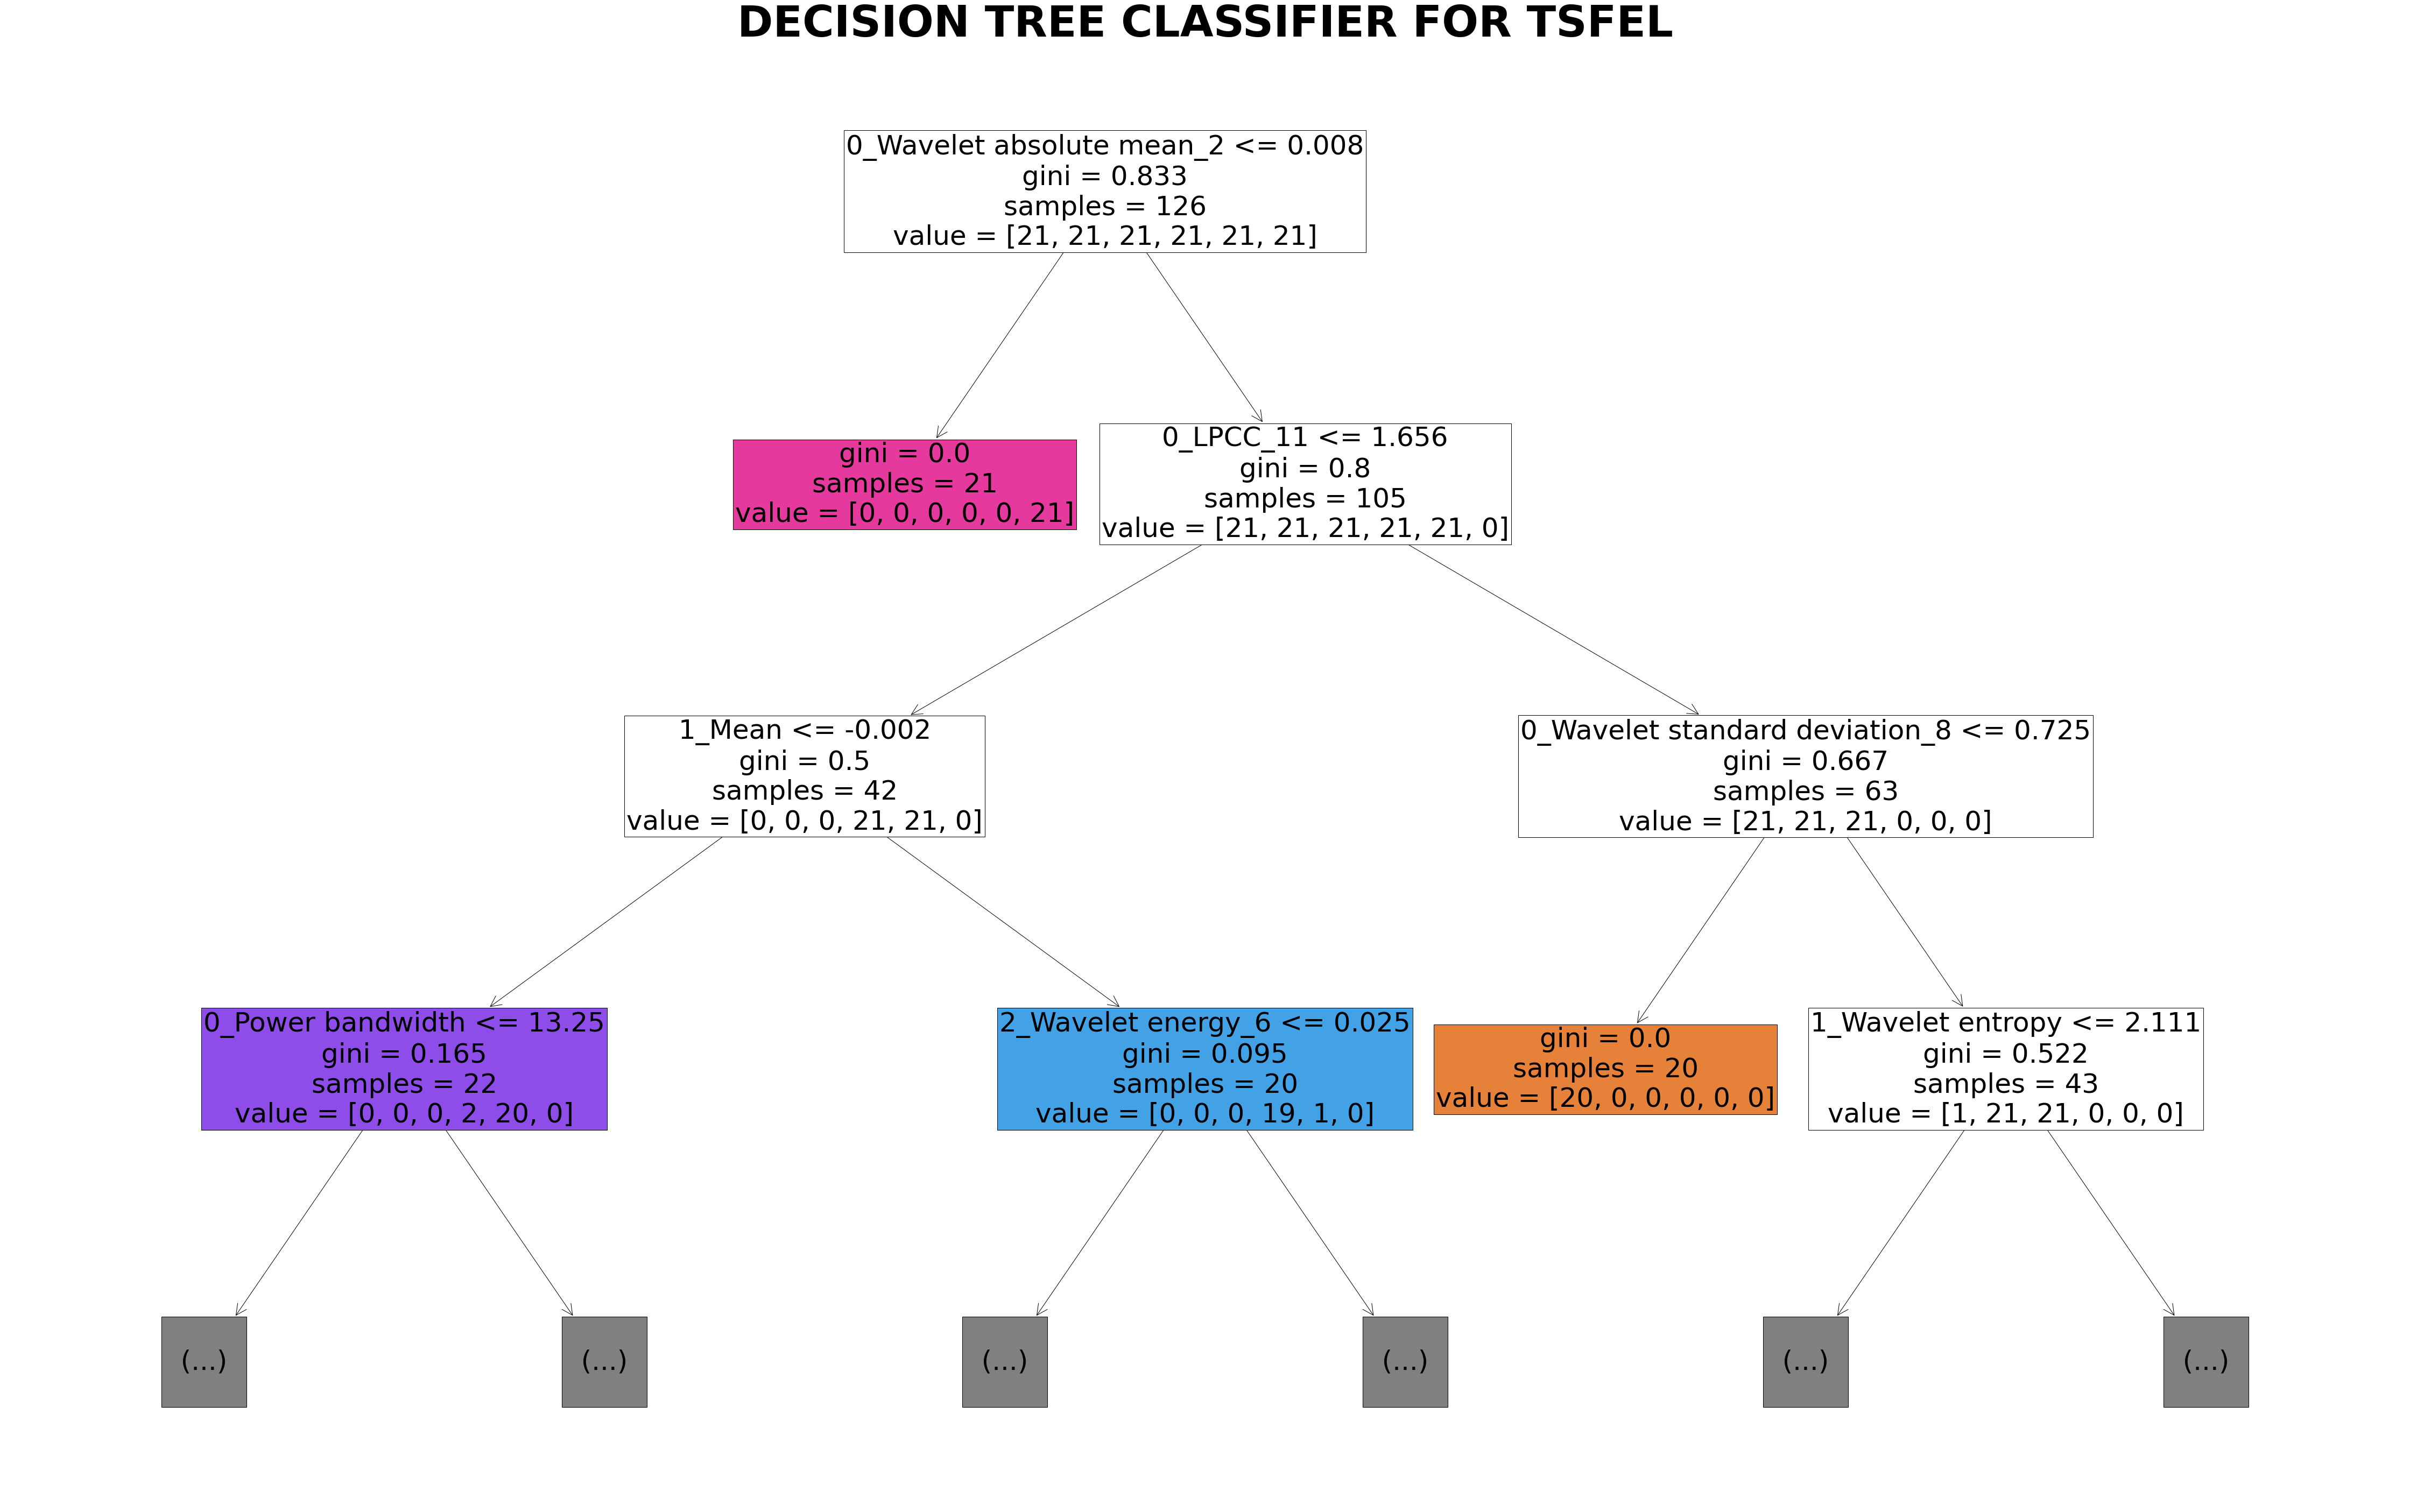

In [130]:
# Plot the decision tree learnt to see the 1'st split (most important feature).

plt.figure(figsize=(80,50))
plot_tree(tree_tsfel,fontsize=50,max_depth=3,filled=True,feature_names=X_train_tsfel.columns)
plt.title('DECISION TREE CLASSIFIER FOR TSFEL',fontsize=80,fontweight='bold')
plt.show()

Lets try to verify that 0_Wavelet absolute mean_2 is indeed an important feature 

In [131]:
X_train_tsfel['label']=y_train
tree_rules=export_text(tree_tsfel,feature_names=list(X_train_tsfel.columns[:-1]))
print(tree_rules)

|--- 0_Wavelet absolute mean_2 <= 0.01
|   |--- class: 6
|--- 0_Wavelet absolute mean_2 >  0.01
|   |--- 0_LPCC_11 <= 1.66
|   |   |--- 1_Mean <= -0.00
|   |   |   |--- 0_Power bandwidth <= 13.25
|   |   |   |   |--- class: 5
|   |   |   |--- 0_Power bandwidth >  13.25
|   |   |   |   |--- class: 4
|   |   |--- 1_Mean >  -0.00
|   |   |   |--- 2_Wavelet energy_6 <= 0.02
|   |   |   |   |--- class: 5
|   |   |   |--- 2_Wavelet energy_6 >  0.02
|   |   |   |   |--- class: 4
|   |--- 0_LPCC_11 >  1.66
|   |   |--- 0_Wavelet standard deviation_8 <= 0.73
|   |   |   |--- class: 1
|   |   |--- 0_Wavelet standard deviation_8 >  0.73
|   |   |   |--- 1_Wavelet entropy <= 2.11
|   |   |   |   |--- class: 2
|   |   |   |--- 1_Wavelet entropy >  2.11
|   |   |   |   |--- 0_FFT mean coefficient_32 <= 0.00
|   |   |   |   |   |--- 0_Wavelet variance_4 <= 0.59
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- 0_Wavelet variance_4 >  0.59
|   |   |   |   |   |   |--- class: 2
|   |   |  

c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

Text(0.5, 1.0, 'First Split i.e (0_Wavelet absolute mean_2)')

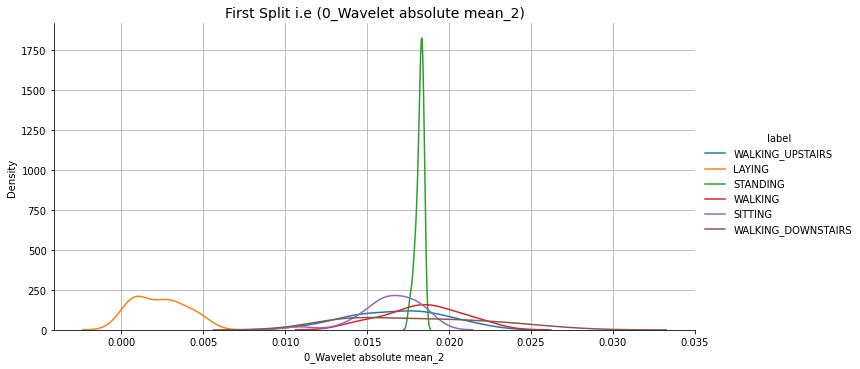

In [132]:
reverse_classes = {v: k for k, v in classes.items()}
X_train_tsfel['label']=X_train_tsfel['label'].map(reverse_classes)
facetgrid=sns.FacetGrid(X_train_tsfel,hue='label',height=5,aspect=2)
plt.grid(True)
facetgrid.map(sns.kdeplot,'0_Wavelet absolute mean_2').add_legend()
plt.title('First Split i.e (0_Wavelet absolute mean_2)',fontsize=14)

We can see that indeed this is an important feature, distribution for Laying class is totally different from otheres, while other classes are also quite distinguishable (like standing).

##### (iii)Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model

READING THE GIVEN DATASET

Read the given dataset i.e features.txt

In [133]:
# Read the feature names from features.txt

features=[]
with open('UCI HAR Dataset/features.txt') as f:
    features=[line.split()[1] for line in f.readlines()]
print(f'Total features: {len(features)}')

Total features: 561


In [134]:
# Read the training data from X_train.txt
X_train_extracted = pd.read_csv('UCI HAR Dataset/train/X_train.txt',delim_whitespace=True,header=None)
X_train_extracted.columns=features

# Read the subject numbmer from subject_train.csv 
X_train_extracted['subject'] = pd.read_csv('UCI HAR Dataset/train/subject_train.txt',delim_whitespace=True,header=None).squeeze()

# Read the y labels of training data from y_train.csv
y_train_extracted=pd.read_csv('UCI HAR Dataset/train/y_train.txt',names=['Activity']).squeeze()

train=X_train_extracted
train['Activity'] = y_train_extracted
train['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

# Printing shapes
print(f'X_train_extracted shape: {X_train_extracted.shape}')
print(f'y_train_extracted shape: {y_train_extracted.shape}')
print(f'train shape: {train.shape}')

C:\Users\vinny\AppData\Local\Temp\ipykernel_7860\1537994812.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_extracted = pd.read_csv('UCI HAR Dataset/train/X_train.txt',delim_whitespace=True,header=None)


X_train_extracted shape: (7352, 564)
y_train_extracted shape: (7352,)
train shape: (7352, 564)


C:\Users\vinny\AppData\Local\Temp\ipykernel_7860\1537994812.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_extracted['subject'] = pd.read_csv('UCI HAR Dataset/train/subject_train.txt',delim_whitespace=True,header=None).squeeze()


In [135]:
# Read the test data from X_test.txt
X_test_extracted=pd.read_csv('UCI HAR Dataset/test/X_test.txt',delim_whitespace=True,header=None)
X_test_extracted.columns=features
X_test_extracted['subject']=pd.read_csv('UCI HAR Dataset/test/subject_test.txt',delim_whitespace=True,header=None).squeeze()

# Read the y labels of test data from y_test.txt
y_test_extracted=pd.read_csv('UCI HAR Dataset/test/y_test.txt',names=['Activity']).squeeze()

test=X_test_extracted
test['Activity']=y_test_extracted
test['ActivityName']=test['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

#Printing shapes
print(f'X_test_extracted shape: {X_test_extracted.shape}')
print(f'y_test_extracted shape: {y_test_extracted.shape}')
print(f'test shape: {test.shape}')

C:\Users\vinny\AppData\Local\Temp\ipykernel_7860\3195010858.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_extracted=pd.read_csv('UCI HAR Dataset/test/X_test.txt',delim_whitespace=True,header=None)


X_test_extracted shape: (2947, 564)
y_test_extracted shape: (2947,)
test shape: (2947, 564)


C:\Users\vinny\AppData\Local\Temp\ipykernel_7860\3195010858.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_extracted['subject']=pd.read_csv('UCI HAR Dataset/test/subject_test.txt',delim_whitespace=True,header=None).squeeze()


In [136]:
print(f'Number of NaN elements in train: {train.isna().values.sum()}')
print(f'Number of Null elements in train: {train.isnull().values.sum()}')
print()
print(f'Number of NaN elements in test: {test.isna().values.sum()}')
print(f'Number of Null elements in test: {test.isnull().values.sum()}')

Number of NaN elements in train: 0
Number of Null elements in train: 0

Number of NaN elements in test: 0
Number of Null elements in test: 0


In [137]:
df_train_x=train.drop(['Activity','ActivityName','subject'],axis=1)
df_train_y=train['Activity']
df_test_x=test.drop(['Activity','ActivityName','subject'],axis=1)
df_test_y=test['Activity']

In [164]:
# Initializing a decision tree, followed by learning and making predicitons

tree_extracted=DecisionTreeClassifier()
tree_extracted.fit(df_train_x,df_train_y)
predictions_extracted=tree_extracted.predict(df_test_x)

CLASSIFICATION REPORT FOR TREE

In [165]:
print(classification_report(df_test_y,predictions_extracted))

              precision    recall  f1-score   support

           1       0.83      0.91      0.87       496
           2       0.81      0.77      0.79       471
           3       0.86      0.82      0.84       420
           4       0.83      0.76      0.79       491
           5       0.79      0.86      0.82       532
           6       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.85      0.85      2947
weighted avg       0.86      0.86      0.86      2947



CONFUSION MATRIX FOR TREE

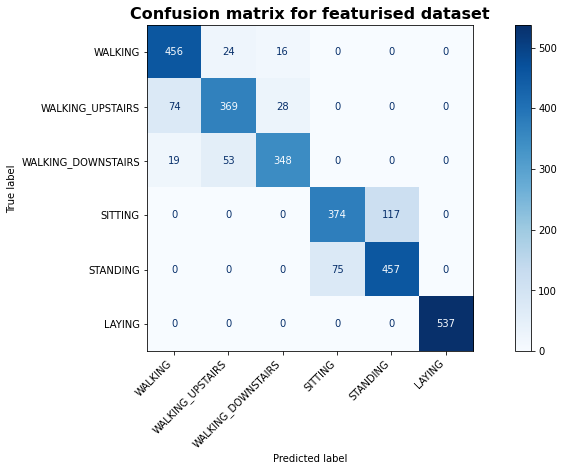

In [140]:
cm=confusion_matrix(df_test_y,predictions_extracted)
fig,ax=plt.subplots(figsize=(15,6))
cm=ConfusionMatrixDisplay(cm,display_labels=classes)
cm.plot(cmap='Blues',ax=ax)
plt.title('Confusion matrix for featurised dataset',fontweight='bold',fontsize=16)
plt.xticks(rotation=45,ha='right')
plt.show()

In [141]:
tree_rules=export_text(tree_extracted,feature_names=list(df_train_x.columns))
print(tree_rules)

|--- tGravityAcc-min()-X <= 0.10
|   |--- class: 6
|--- tGravityAcc-min()-X >  0.10
|   |--- fBodyAccJerk-bandsEnergy()-1,16 <= -0.97
|   |   |--- angle(Y,gravityMean) <= 0.14
|   |   |   |--- tGravityAcc-energy()-Y <= -1.00
|   |   |   |   |--- tGravityAcc-min()-Z <= 0.06
|   |   |   |   |   |--- tGravityAcc-min()-Z <= -0.20
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- tGravityAcc-min()-Z >  -0.20
|   |   |   |   |   |   |--- class: 5
|   |   |   |   |--- tGravityAcc-min()-Z >  0.06
|   |   |   |   |   |--- tBodyGyroJerk-max()-X <= -0.98
|   |   |   |   |   |   |--- tBodyAccJerk-arCoeff()-X,3 <= 0.41
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- tBodyAccJerk-arCoeff()-X,3 >  0.41
|   |   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |--- tBodyGyroJerk-max()-X >  -0.98
|   |   |   |   |   |   |--- class: 5
|   |   |   |--- tGravityAcc-energy()-Y >  -1.00
|   |   |   |   |--- tBodyGyro-max()-X <= -0.87
|   |   |   |   |   |--- tBodyGyro

Lets try to see the leart tree

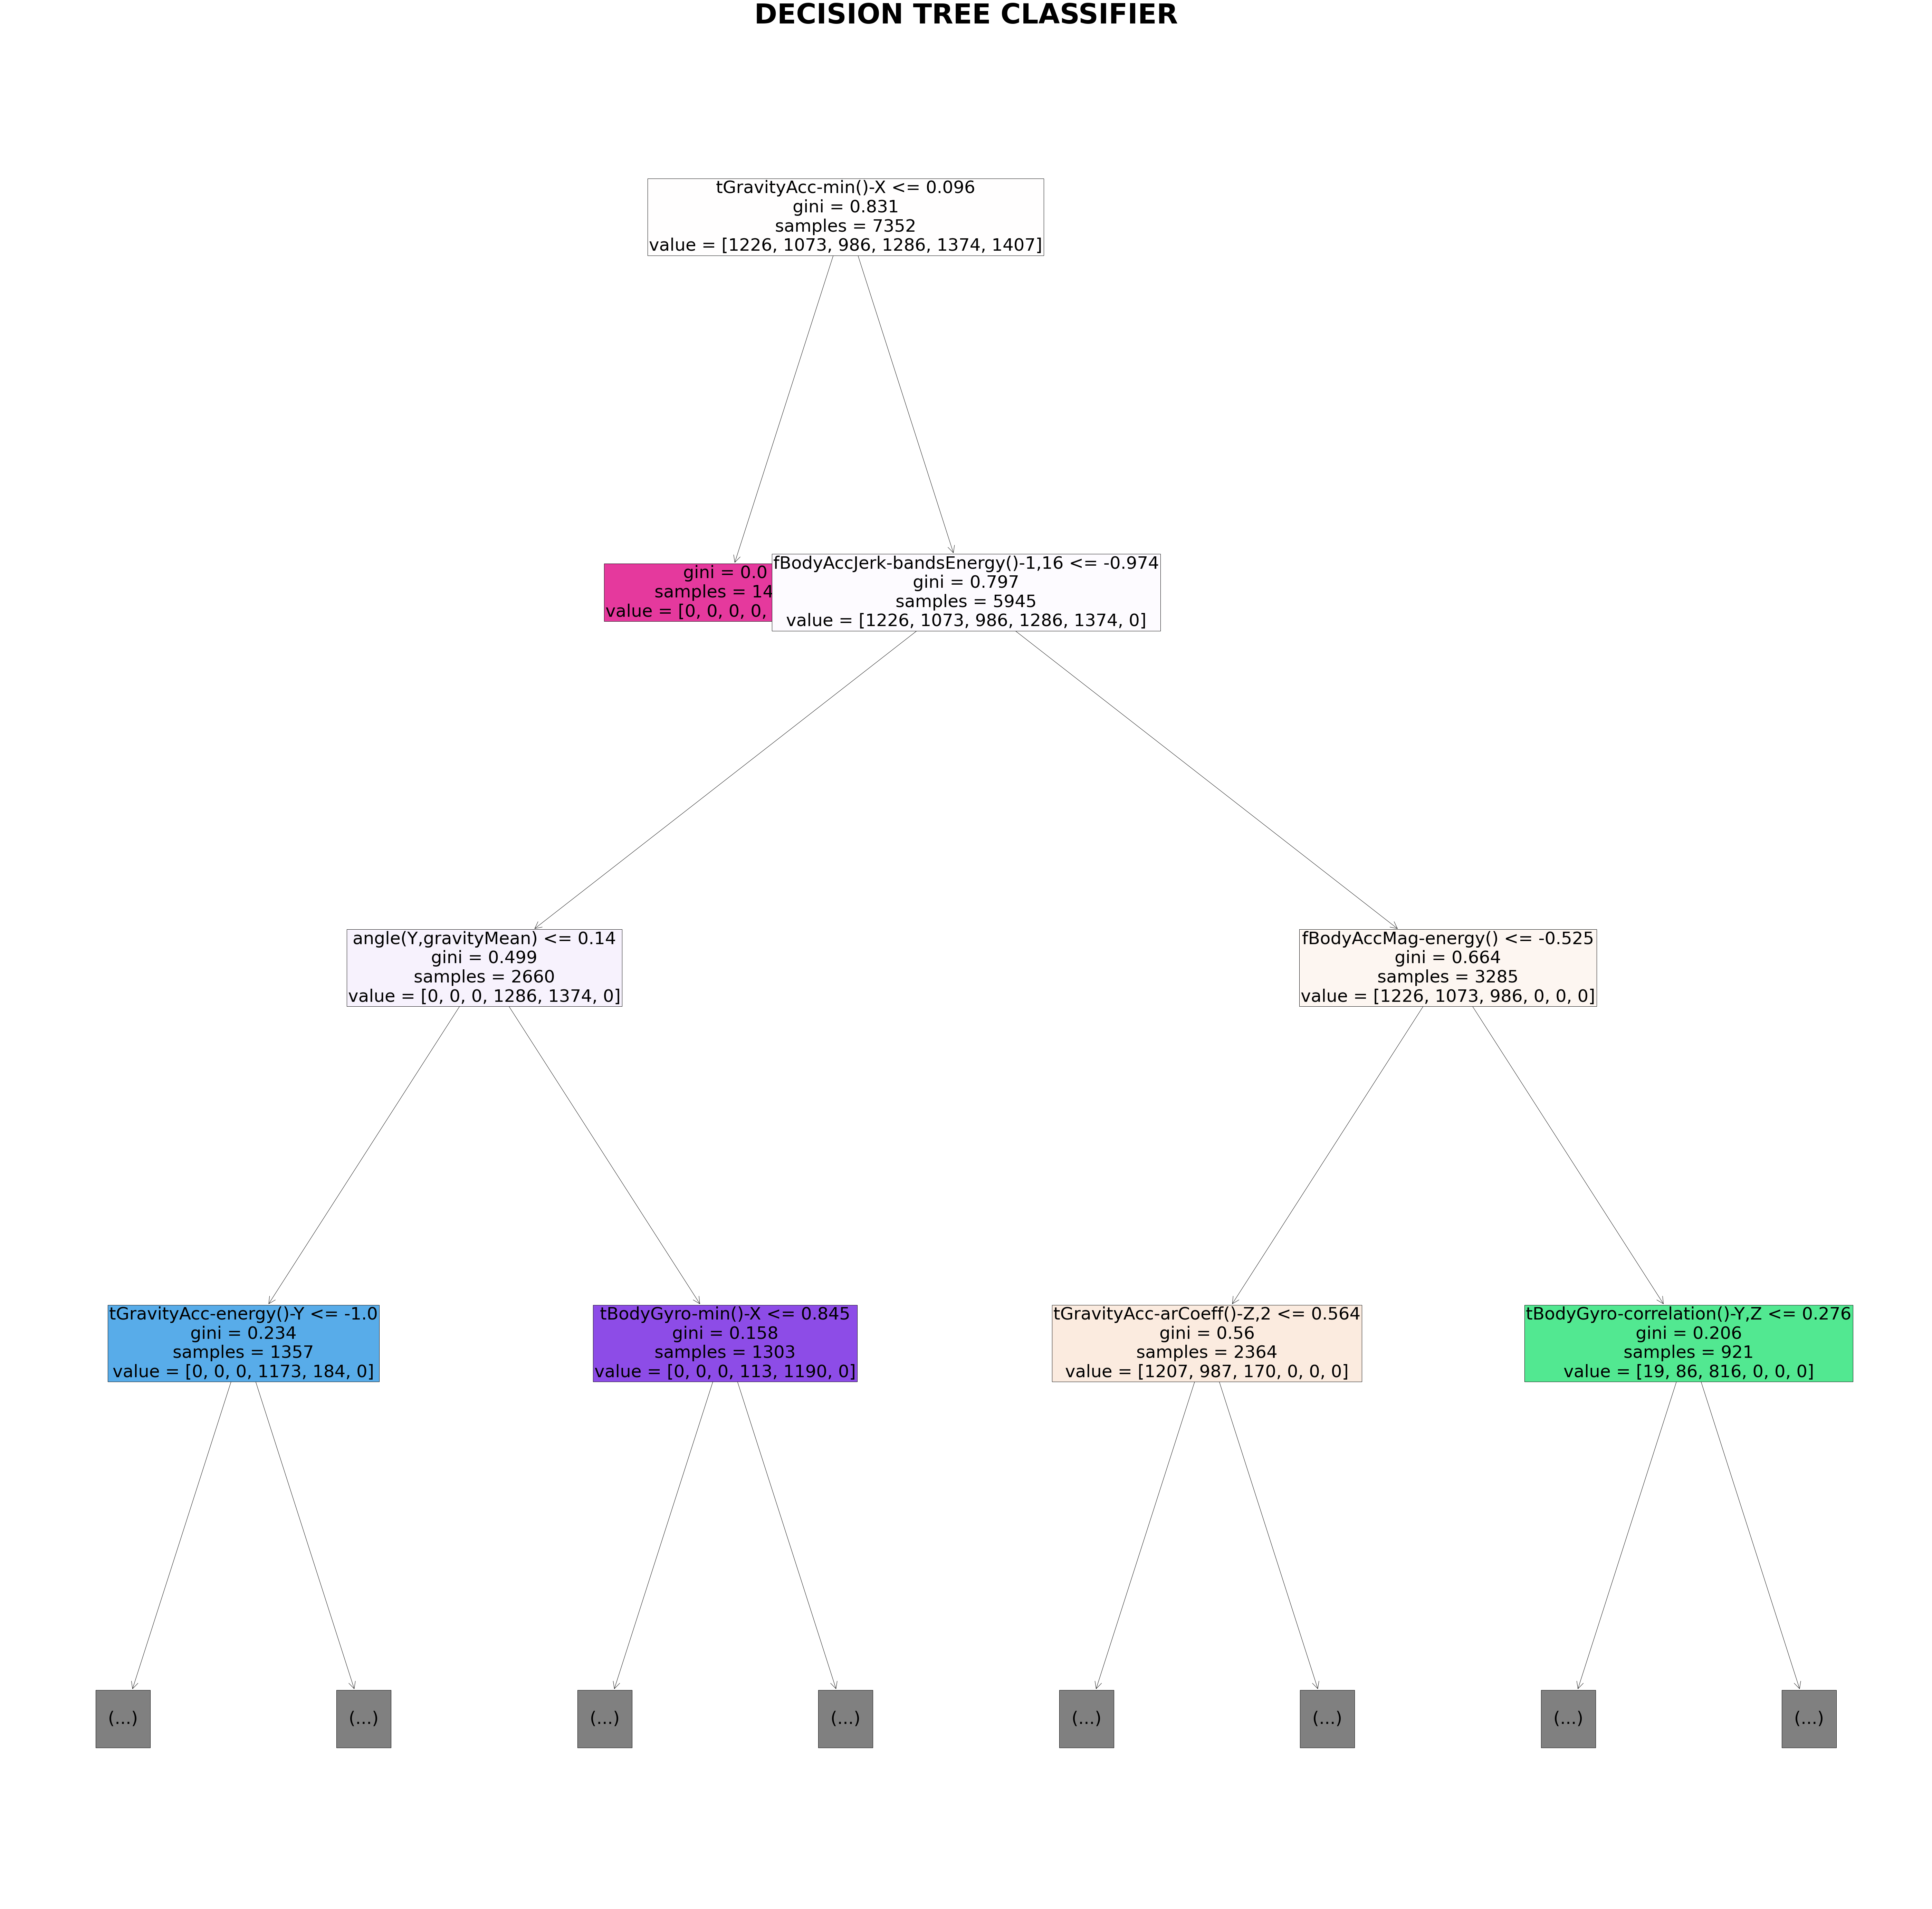

In [142]:
plt.figure(figsize=(100,100))
plot_tree(tree_extracted,feature_names=df_train_x.columns,filled=True,max_depth=3,fontsize=50)
plt.title('DECISION TREE CLASSIFIER',fontsize=80,fontweight='bold')
plt.show()

Let us again try to verify the most important feature i.e tGravityAcc-min()-X

c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

Text(0.5, 1.0, 'First Split i.e (tGravityAcc-min()-X)')

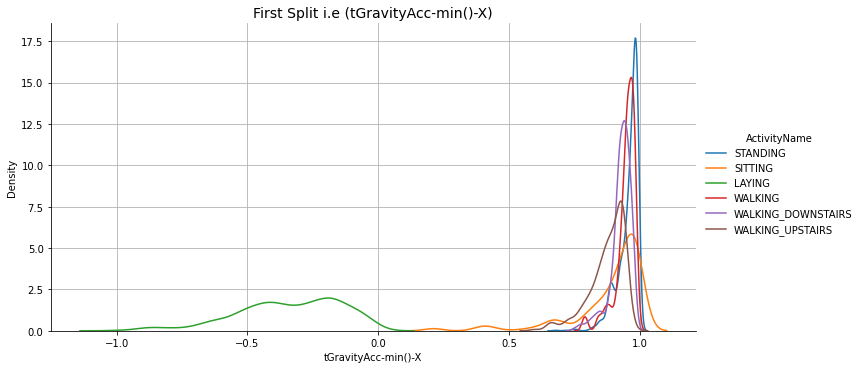

In [143]:
# Lets try the 
facetgrid=sns.FacetGrid(train,hue='ActivityName',height=5,aspect=2)
plt.grid(True)
facetgrid.map(sns.kdeplot,'tGravityAcc-min()-X').add_legend()
plt.title('First Split i.e (tGravityAcc-min()-X)',fontsize=14)

Lets see some more plot

Text(0.5, 1.0, 'First Split i.e (tGravityAcc-min()-X)')

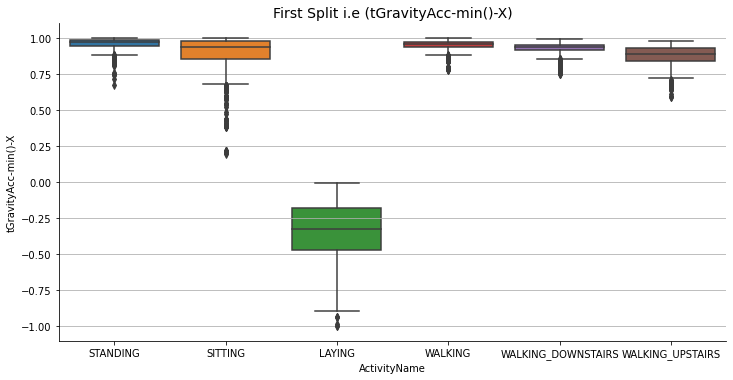

In [144]:
# Box plot

facetgrid=sns.FacetGrid(train,hue='ActivityName',height=5,aspect=2)
plt.grid(True)
sns.boxplot(x='ActivityName',y='tGravityAcc-min()-X',data= train)
plt.title('First Split i.e (tGravityAcc-min()-X)',fontsize=14)

In the featurised dataset also, laying class is easily distinguishable from others, so using tGravityAcc-min()-X we get the maximum info gain in the first split

##### (iv) Compare the results of the three models. Which model do you think is better?

* We have already seen the classification report and confusion matrices of all the models

* In first view, it is visible that the tsfel model and the model trained on featuresed dataset perform very close to each other.

* However, the amount of data that both the models have been trained on is very different, lets see some numbers

In [145]:
print(f'X_train shape = {X_train.shape}')
print(f'X_train tsfel = {X_train_tsfel.shape}')
print(f'X_train featurised = {X_train_extracted.shape}')

X_train shape = (126, 500, 3)
X_train tsfel = (126, 1153)
X_train featurised = (7352, 564)


* Although tsfel model is trained on a relatively smaller amount of data than the featurised dataset model, still it performs better than all other models.

* This is because of the fact that tsfel is dataset contains features that are much richer in context than just the raw numbers.

* Note that it takes a lot of training examples for a decision tree using raw data to learn the patterns and trends learnt by the tsfel model with very less data points.

So definately, model trained on TSFEL dataset is much better than the rest.

What if we train the decision tree on featurised dataset, but with the same number of samples as tsfel is trained?


In [146]:
# Checking class distribution
pd.Series(y_train).value_counts()

2    21
6    21
5    21
1    21
4    21
3    21
Name: count, dtype: int64

In [147]:
pd.Series(y_test).value_counts()

3    9
1    9
2    9
5    9
6    9
4    9
Name: count, dtype: int64

In [148]:
# Lets mimic the class distribution in tsfel dataset 

df_train_temp=pd.DataFrame()
for Activity in train['ActivityName'].unique():
    activity_data=train[train['ActivityName']==Activity].iloc[:21]
    df_train_temp=pd.concat([df_train_temp,activity_data],axis=0)
df_train_temp=df_train_temp.sample(frac=1).reset_index(drop=True)

In [149]:

df_test_temp=pd.DataFrame()
for Activity in test['ActivityName'].unique():
    activity_data=test[test['ActivityName']==Activity].iloc[:9]
    df_test_temp=pd.concat([df_test_temp,activity_data],axis=0)
df_test_temp=df_test_temp.sample(frac=1).reset_index(drop=True)


In [150]:

df_train_temp_x=df_train_temp.drop(['Activity','ActivityName','subject'],axis=1)
df_train_temp_y=df_train_temp['Activity']
df_test_temp_x=df_test_temp.drop(['Activity','ActivityName','subject'],axis=1)
df_test__temp_y=df_test_temp['Activity']

In [151]:
# Training decision tree on this class

tree_extracted=DecisionTreeClassifier(random_state=42)
tree_extracted.fit(df_train_temp_x,df_train_temp_y)
predictions_extracted=tree_extracted.predict(df_test_temp_x)

CLASSIFICATION REPORT

In [152]:
print(classification_report(df_test__temp_y,predictions_extracted))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.25      0.11      0.15         9
           3       0.41      1.00      0.58         9
           4       0.00      0.00      0.00         9
           5       0.50      1.00      0.67         9
           6       1.00      1.00      1.00         9

    accuracy                           0.52        54
   macro avg       0.36      0.52      0.40        54
weighted avg       0.36      0.52      0.40        54



c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vinny\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

The accuracy falls, so it seems that the data is less contextually rich than the data extracted by tsfel.

### Q2 Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree.

In [153]:
# Raw data

accuracies_raw = []

for depth in range(2, 9):
    accuracy_runs = []
    
    for _ in range(10):
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train_flat, y_train)
        predictions = clf.predict(X_test_flat)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_runs.append(accuracy * 100)
    
    mean_accuracy = np.mean(accuracy_runs)
    accuracies_raw.append(mean_accuracy)


In [154]:
accuracies_raw

[42.592592592592595,
 53.70370370370371,
 58.33333333333333,
 58.51851851851851,
 62.03703703703703,
 59.62962962962962,
 62.407407407407405]

In [155]:
# tsfel data

X_train_tsfel.drop(['label'],axis=1,inplace=True) # removing the label column which we added previously to plot some plots

accuracies_tsfel = []

for depth in range(2, 9):
    accuracy_runs = []
    
    for _ in range(10):
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(X_train_tsfel, y_train)
        predictions = clf.predict(X_test_tsfel)
        accuracy = accuracy_score(y_test, predictions)
        accuracy_runs.append(accuracy * 100)
    
    mean_accuracy = np.mean(accuracy_runs)
    accuracies_tsfel.append(mean_accuracy)


In [156]:
accuracies_tsfel

[49.81481481481482,
 74.44444444444446,
 85.92592592592594,
 84.81481481481482,
 84.44444444444446,
 84.81481481481482,
 86.11111111111111]

In [159]:
# given data

accuracies_given = []

for depth in range(2, 9):
    accuracy_runs = []
    
    for _ in range(10):
        clf = DecisionTreeClassifier(max_depth=depth)
        clf.fit(df_train_x, df_train_y)
        predictions = clf.predict(df_test_x)
        accuracy = accuracy_score(df_test_y, predictions)
        accuracy_runs.append(accuracy * 100)
    
    mean_accuracy = np.mean(accuracy_runs)
    accuracies_given.append(mean_accuracy)


In [160]:
accuracies_given

[53.10485239226331,
 72.24295894129624,
 80.96369189005769,
 83.84119443501866,
 85.51068883610449,
 86.44384119443501,
 87.29216152019004]

PLOTS FOR ACCURACIES OF VARIOUS MODELS ON DIFFERENT DEPTHS

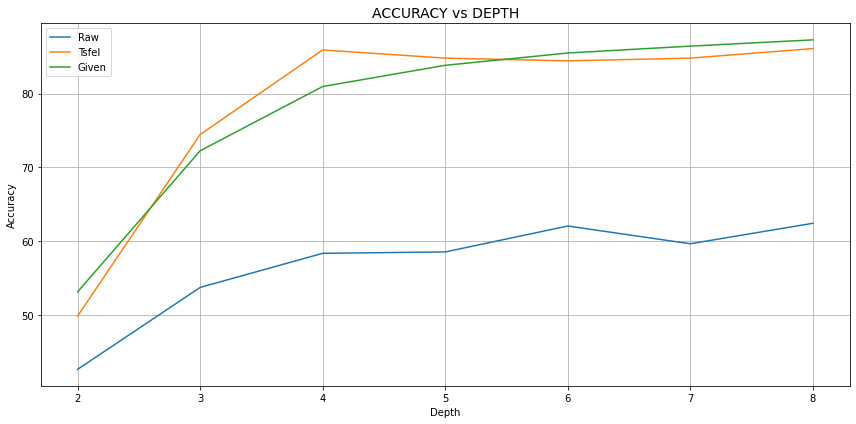

In [161]:
depths=range(2,9)
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(depths,accuracies_raw,label='Raw')
plt.plot(depths,accuracies_tsfel,label='Tsfel')
plt.plot(depths,accuracies_given,label='Given')
plt.title('ACCURACY vs DEPTH',fontsize=14)
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

### Q3 Are there any participants/ activitivies where the Model performace is bad? If Yes, Why?

* Yes, in general, the dynamic activities (walking, walking down/up) are difficult to differentiate. Although tsfel is performing very good on those activities as well, but there are still some misclassifications in that area, while the static activities are almost correct every time.

* As we saw in the timeseries plot as well, dynamic activities were difficult to distinguish. This is the reason that the tree is not able to classify among the (difficult to distinguish classes) i.e the dynamic activities

THANK YOU